# 肺野セグメンテーション
参考 [Image segmentation  |  TensorFlow Core](https://www.tensorflow.org/tutorials/images/segmentation)

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
IMAGE_DIR = 'regular'
LABEL_DIR = 'lung'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, image_dir, label_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(image_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['image_path'])
    df['label_path'] = df['image_path'].map(
        lambda p: root / pathlib.Path(label_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, IMAGE_DIR, LABEL_DIR, IMAGE_EXT)
display(df_dataset)

,image_path,label_path
0,Data\Images\chest_xray\regular\000.png,Data\Images\chest_xray\lung\000.png
1,Data\Images\chest_xray\regular\001.png,Data\Images\chest_xray\lung\001.png
2,Data\Images\chest_xray\regular\002.png,Data\Images\chest_xray\lung\002.png
3,Data\Images\chest_xray\regular\003.png,Data\Images\chest_xray\lung\003.png
4,Data\Images\chest_xray\regular\004.png,Data\Images\chest_xray\lung\004.png
...,...,...
280,Data\Images\chest_xray\regular\280.png,Data\Images\chest_xray\lung\280.png
281,Data\Images\chest_xray\regular\281.png,Data\Images\chest_xray\lung\281.png
282,Data\Images\chest_xray\regular\282.png,Data\Images\chest_xray\lung\282.png
283,Data\Images\chest_xray\regular\283.png,Data\Images\chest_xray\lung\283.png


### 画像を表示
入力画像を背景にセグメンテーションを重畳表示する

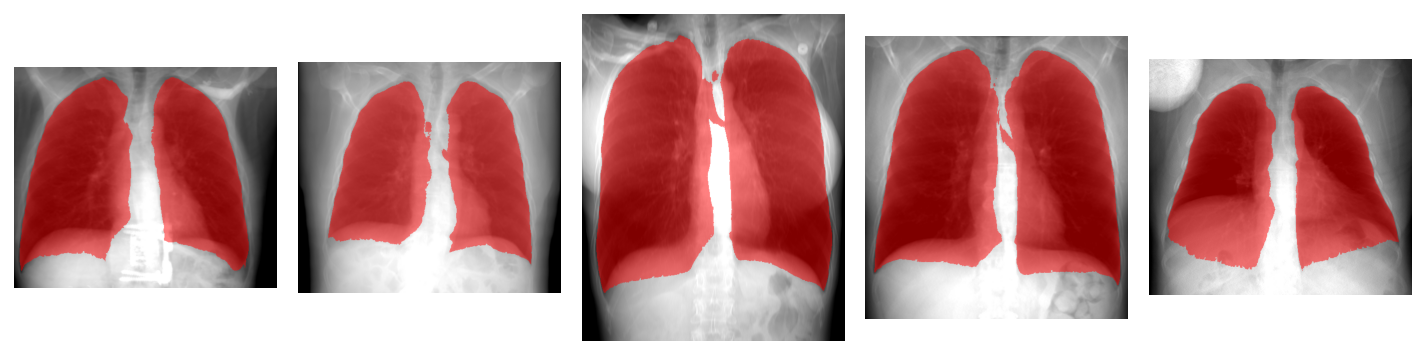

In [4]:
OVERLAY_ALPHA = 0.5
cmap = np.array([[0, 0, 0, 0], [255, 0, 0,
                                255 * OVERLAY_ALPHA]]).astype(np.uint8)

N_SAMPLES = 5
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.image_path).convert('RGBA')
    label = np.array(Image.open(sample.label_path).convert('L'))
    label = (label > 0).astype(np.uint8)
    label = Image.fromarray(cmap[label])
    plt.subplot(1, N_SAMPLES, i + 1)
    plt.imshow(Image.alpha_composite(image, label))
    plt.axis('off')
plt.tight_layout()
plt.show()

### ホールドアウト
学習に時間がかかるため、今回は交差検証は行わない。

In [5]:
from sklearn.model_selection import KFold
N_SPLITS = 5
kfold = KFold(n_splits=N_SPLITS, shuffle=True)
train_index, test_index = next(kfold.split(df_dataset['image_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]
print('training:', len(df_train), 'test:', len(df_test))

training: 228 test: 57


## モデル作成
MobileNetV2をベースにする。[参考](https://www.tensorflow.org/tutorials/images/segmentation "参考")

In [6]:
import tensorflow as tf


# from https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    ''' Upsamples an input.

    Conv2DTranspose => Batchnorm => Dropout => Relu

    Args:
      filters: number of filters
      size: filter size
      norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
      apply_dropout: If True, adds the dropout layer

    Returns:
      Upsample Sequential Model
    '''

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,
                                        size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=True))
    result.add(tf.keras.layers.Activation('relu'))

    result.add(
        tf.keras.layers.Conv2D(filters,
                               size,
                               strides=1,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(tf.keras.layers.Activation('relu'))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(
        tf.keras.layers.Conv2D(filters,
                               size,
                               strides=1,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(tf.keras.layers.Activation('relu'))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

### Skip connectionとデコーダー
- Encoder(MobileNetV2)にSkip connectionとデコーダーを追加する。
- 入力サイズ512は大きすぎるのでAveragePooling2Dで小さくする。

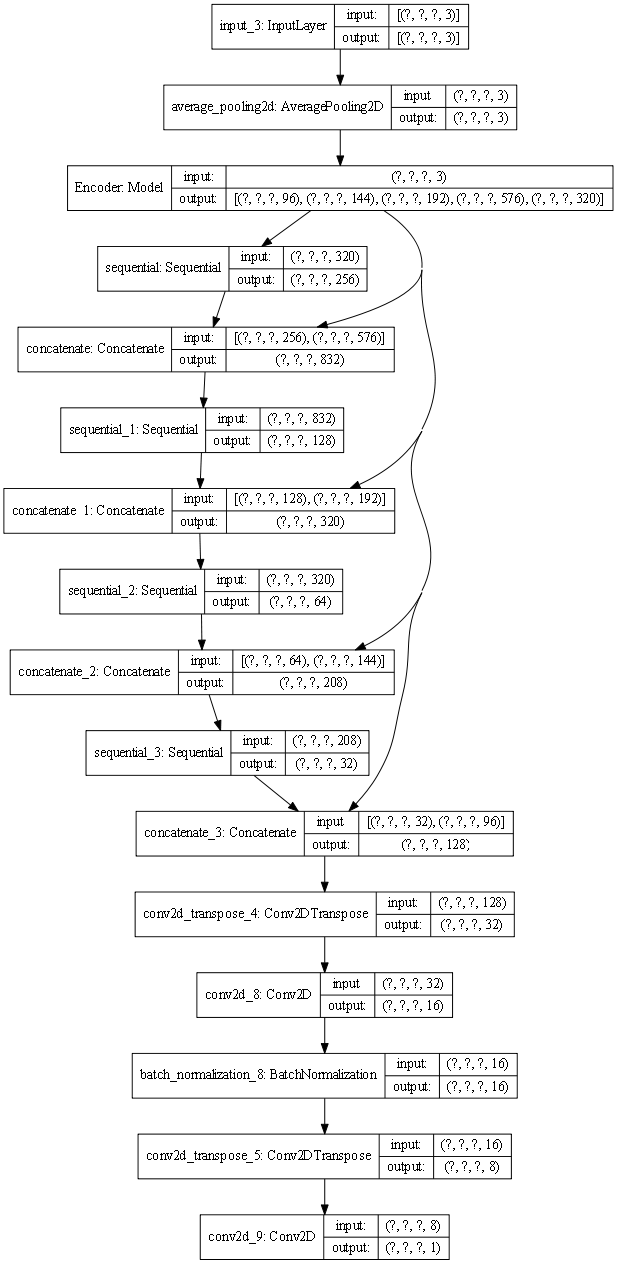

In [7]:
def create_segmentation_model(input_shape):
    base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3],
                                                   include_top=False,
                                                   weights=None)

    base_weights = tf.keras.applications.MobileNetV2(
        input_shape=[224, 224,
                     3], include_top=False, weights='imagenet').get_weights()

    base_model.set_weights(base_weights)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',  # 64x64
        'block_3_expand_relu',  # 32x32
        'block_6_expand_relu',  # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',  # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input,
                                outputs=layers,
                                name='Encoder')

    down_stack.trainable = False

    up_stack = [
        upsample(256, 3),  # 4x4 -> 8x8
        upsample(128, 3),  # 8x8 -> 16x16
        upsample(64, 3),  # 16x16 -> 32x32
        upsample(32, 3),  # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.AveragePooling2D(2)(inputs)  # down sampling

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    x = tf.keras.layers.Conv2DTranspose(32,
                                        3,
                                        strides=2,
                                        activation='relu',
                                        padding='same')(x)  #64x64 -> 128x128

    x = tf.keras.layers.Conv2D(16,
                               3,
                               strides=1,
                               padding='same',
                               activation='relu')(x)

    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(8,
                                        3,
                                        strides=2,
                                        activation='relu',
                                        padding='same')(x)  #64x64 -> 128x128

    x = tf.keras.layers.Conv2D(1, 3, strides=1, padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


model = create_segmentation_model((None, None, 3))
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

## 学習
### tf.data.Datasetを作成
kerasのImageDataGeneratorがsemantic segmentationの場合使えなかったので、tensorflowのDatasetを使う。

In [9]:
import tqdm
IMG_SHAPE = (512, 512, 3)


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(filepath, target_size=IMG_SHAPE))


dataset = tf.data.Dataset.from_tensor_slices((
    np.stack([
        load_img(filepath) for filepath in tqdm.tqdm(df_train['image_path'])
    ]),
    np.stack([
        load_img(filepath)[..., :1]
        for filepath in tqdm.tqdm(df_train['label_path'])
    ]),
))

print(dataset.element_spec)

100%|██████████| 228/228 [00:00<00:00, 379.20it/s]


(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.uint8, name=None))


### Data augmentation
回転、左右反転等をランダムに適用する。

2020-06-16 10:36:04,518 WARNING :Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


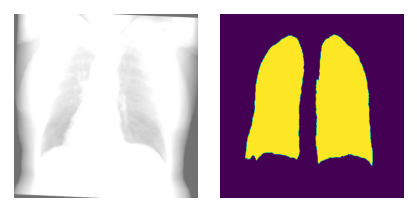

In [10]:
import tensorflow_addons as tfa


def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.image.convert_image_dtype(label, tf.float32)
    label > 0
    return image, label


MAX_ANGLE_DEG = 10
MAX_ANGLE_RAD = np.deg2rad(MAX_ANGLE_DEG)
FLIP_RATE = .5
BRIGHTNESS_RANGE = .5


def augment(image, label):
    image, label = convert(image, label)
    # rotate
    angle = tf.random.uniform((), minval=-MAX_ANGLE_RAD, maxval=MAX_ANGLE_RAD)
    image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    label = tfa.image.rotate(label, angle, interpolation='NEAREST')

    # flip
    if tf.random.uniform(()) < FLIP_RATE:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # brightness
    image = image + tf.random.uniform(
        (), minval=-BRIGHTNESS_RANGE, maxval=BRIGHTNESS_RANGE)

    return image, label


for d in dataset.map(augment):
    plt.figure(figsize=(3, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(d[0])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(d[1][..., 0])
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

### Fit

In [11]:
import tut_utils

AUTOTUNE = tf.data.experimental.AUTOTUNE

EPOCHS = 256
PATIENCE = 16
BATCH_SIZE = 4


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  restore_best_weights=True,
                                                  patience=PATIENCE,
                                                  min_delta=0.002)

logger.info('start of training')
with tut_utils.ProgressBarCallback(EPOCHS,
                         len(train_index) // BATCH_SIZE, BATCH_SIZE) as pbar:
    result = model.fit(dataset.shuffle(BATCH_SIZE * 16).map(
        augment,
        num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE),
                       epochs=EPOCHS,
                       verbose=0,
                       shuffle=False,
                       callbacks=[pbar, early_stopping])
logger.info('end of training')

2020-06-16 10:36:04,721 INFO :start of training
72/256 epoch [4.7m/17m (3.9s/epoch) last_epoch=(loss=0.0371)]:  46%|████▌     | 104/228 [00:02<00:01, 67.20batch/s, loss=0.0383]

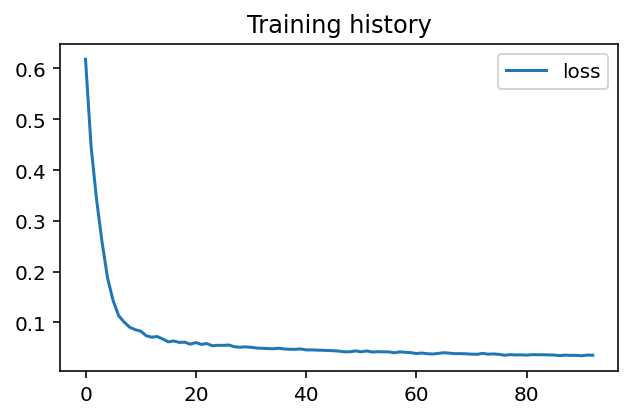

In [12]:
pd.DataFrame(result.history).plot(title='Training history', figsize=(5, 3))
plt.show()

## 評価
Dice similarity coefficient(F1 score)とJaccard Index(IoU)を評価指標とする。

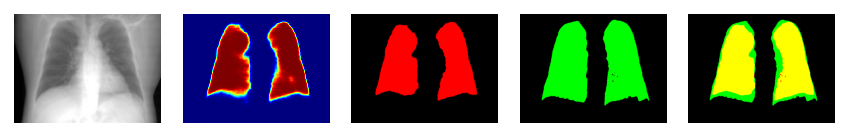

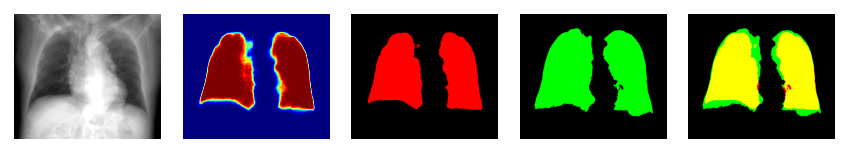

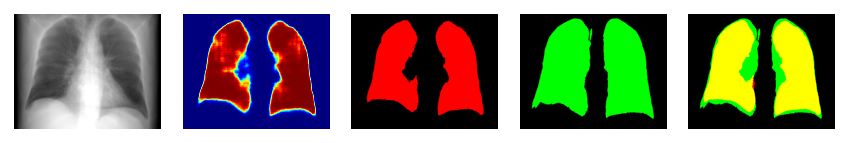

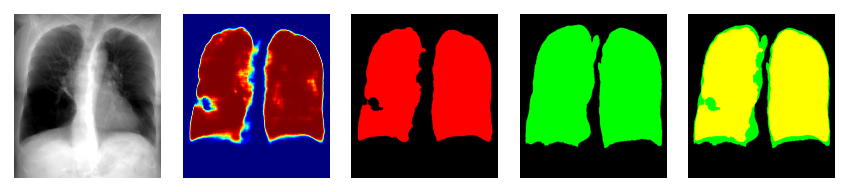

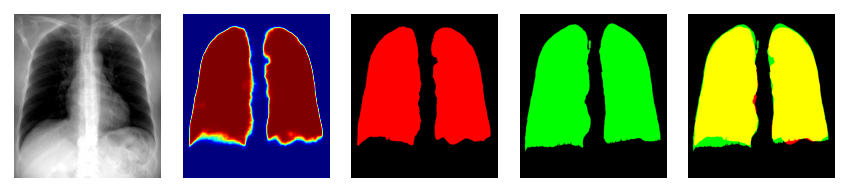

In [13]:
import math
from sklearn import metrics

label_cmap = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0], [255, 255, 0]])

scores = []
for i, index in enumerate(test_index):
    image = tf.keras.preprocessing.image.load_img(
        df_dataset.iloc[index].image_path, color_mode='rgb')
    image = np.atleast_3d(image)
    image = np.array(image) / 255
    padding_size = max(512,
                       math.ceil(image.shape[0] / (2**6)) *
                       (2**6)) - image.shape[0]
    padded_image = np.pad(image, ((0, padding_size), (0, 0), (0, 0)))

    pred = tf.nn.sigmoid(model.predict(
        padded_image[np.newaxis])).numpy().squeeze()
    if padding_size > 0:
        pred = pred[:-padding_size]

    pred_bin = pred > .5
    label = np.array(Image.open(df_dataset.iloc[index].label_path).convert('L')) > 0
    scores.append((metrics.f1_score(label.ravel(), pred_bin.ravel()),
                   metrics.jaccard_score(label.ravel(), pred_bin.ravel())))
    if i < N_SAMPLES:
        plt.subplot(1, 5, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.subplot(1, 5, 2)
        plt.imshow(pred, cmap='jet')
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(label_cmap[[0, 1]][pred_bin.astype(np.uint8)])
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.imshow(label_cmap[[0, 2]][label.astype(np.uint8)])
        plt.axis('off')
        plt.subplot(1, 5, 5)
        plt.imshow(label_cmap[pred_bin + label * 2])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [14]:
df_score = pd.DataFrame(scores,
                        columns=['dice coefficient', 'jaccard index'],
                        index=test_index)
display(df_score.head())
display(
    pd.DataFrame({
        'median': df_score.median(),
        'mean': df_score.mean(),
        'std': df_score.std(),
        'min': df_score.min(),
        'max': df_score.max(),
    }))

,dice coefficient,jaccard index
17,0.883415,0.791176
22,0.896874,0.813030
25,0.882507,0.789720
30,0.916449,0.845784
31,0.959139,0.921486


,median,mean,std,min,max
dice coefficient,0.918764,0.914047,0.026234,0.848364,0.959139
jaccard index,0.849735,0.842747,0.044113,0.736660,0.921486


### 分布の確認
Dice similarity coefficientの分布を表示する。

#### Boxplot

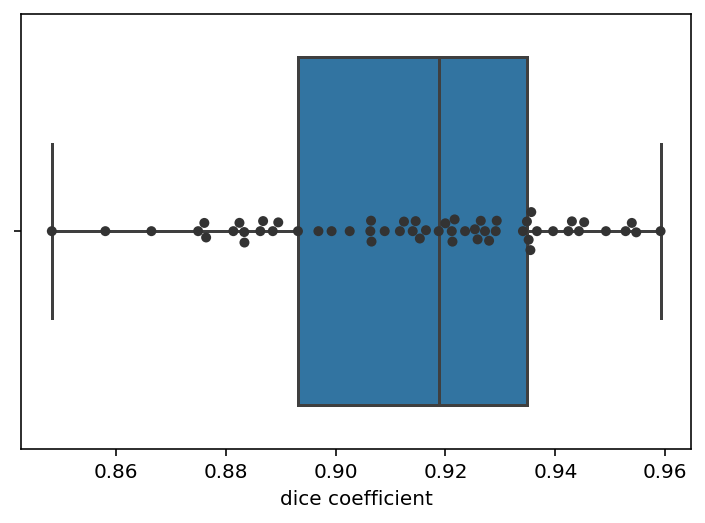

In [15]:
import seaborn as sns
sns.boxplot(x='dice coefficient', data=df_score)
sns.swarmplot(x='dice coefficient', data=df_score, color='.2')
plt.show()

#### Letter value plot

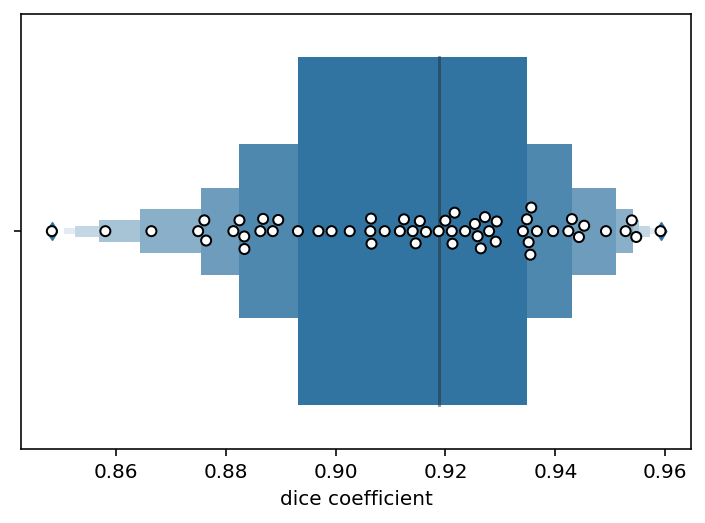

In [16]:
sns.boxenplot(x='dice coefficient', data=df_score)
sns.swarmplot(x='dice coefficient',
              data=df_score,
              color='white',
              edgecolor='black',
              linewidth=1)
plt.show()

#### Violinplot

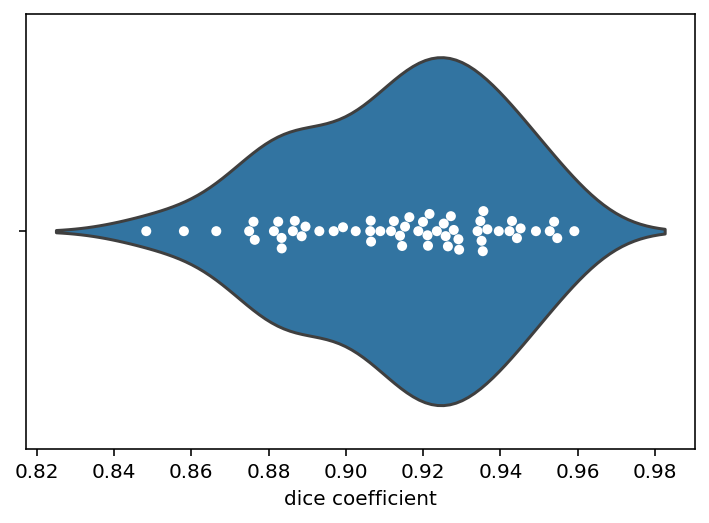

In [17]:
sns.violinplot(x='dice coefficient', data=df_score, inner=None)
sns.swarmplot(x='dice coefficient',
              data=df_score,
              color='white',
              edgecolor='gray')
plt.show()